# $m_A = 0.005$ GeV

## model n = 500

/work/aavocone/anaconda3/envs/Bachelor/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Reading 0_large...
Completed!

Splitting Dataset:
Completed!

Getting probability from trainingsset and testingset
Completed!

Getting efficiency values:
Reconstruction efficiency with n=100.000 calculated.
Reconstruction efficiency with n=100.000 calculated.
Completed!



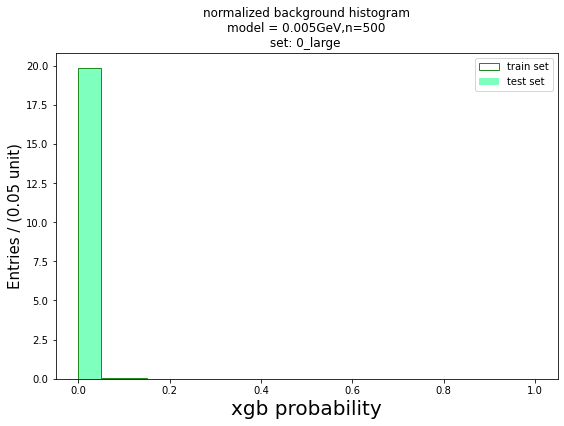

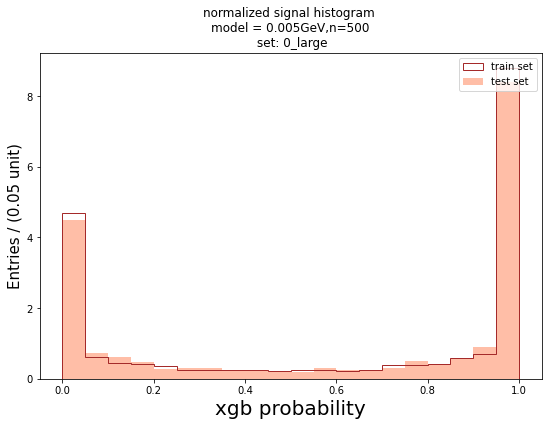

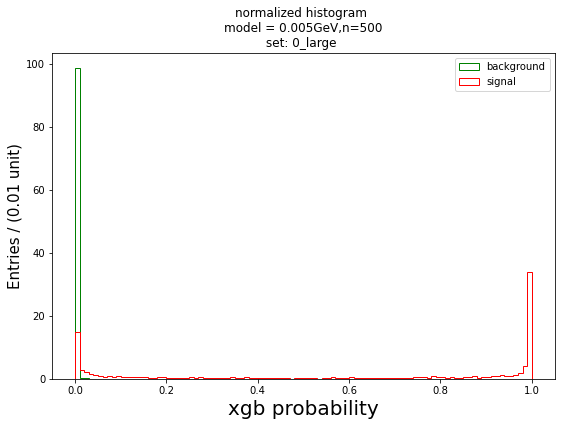

Reading 3_large...
Completed!

Splitting Dataset:
Completed!

Getting probability from trainingsset and testingset
Completed!

Getting efficiency values:
Reconstruction efficiency with n=100.000 calculated.
Reconstruction efficiency with n=100.000 calculated.
Completed!



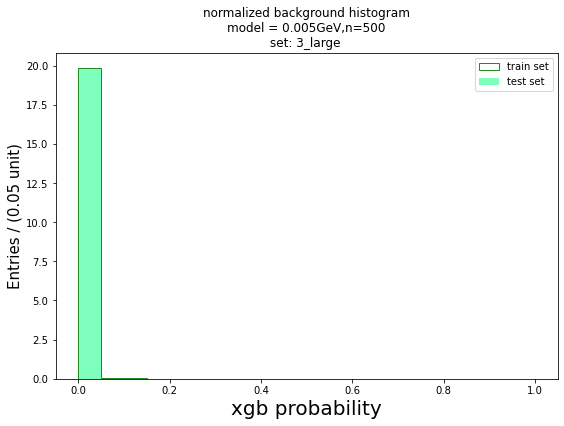

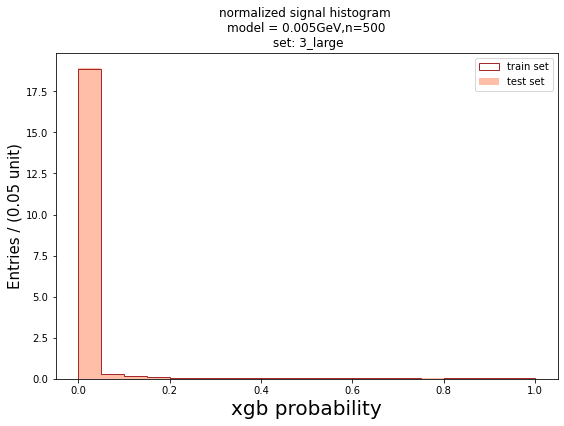

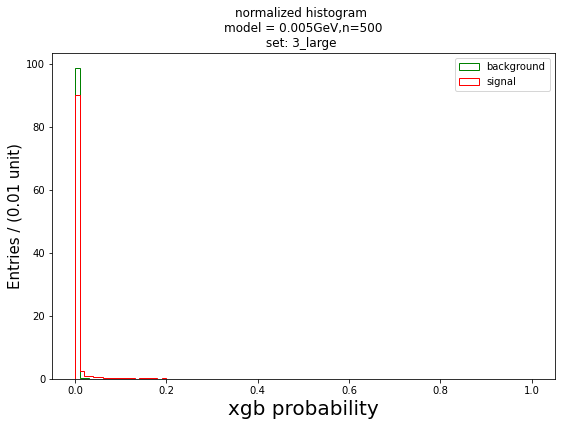

Reading 4_large...
Completed!

Splitting Dataset:
Completed!

Getting probability from trainingsset and testingset
Completed!

Getting efficiency values:
Reconstruction efficiency with n=100.000 calculated.
Reconstruction efficiency with n=100.000 calculated.
Completed!



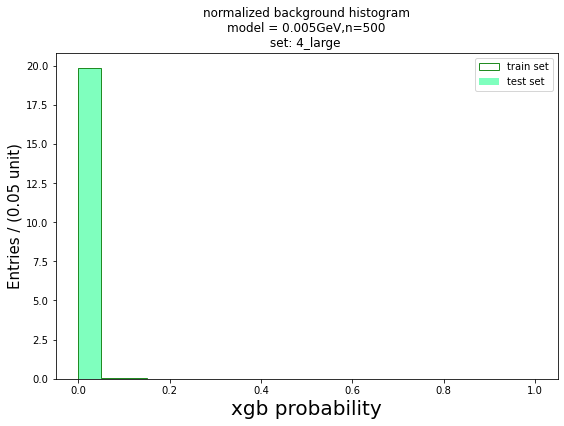

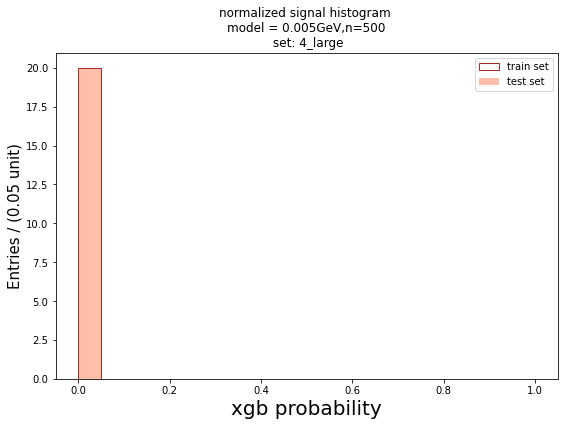

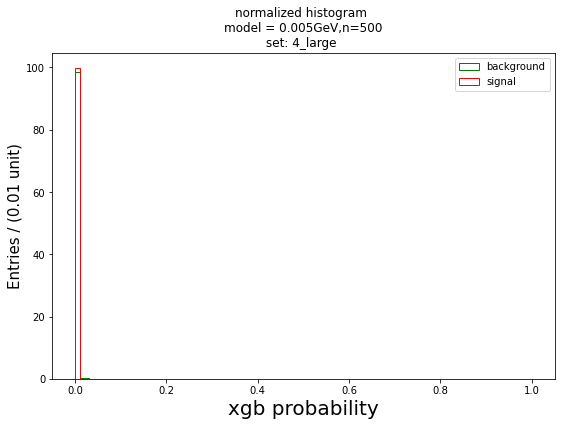

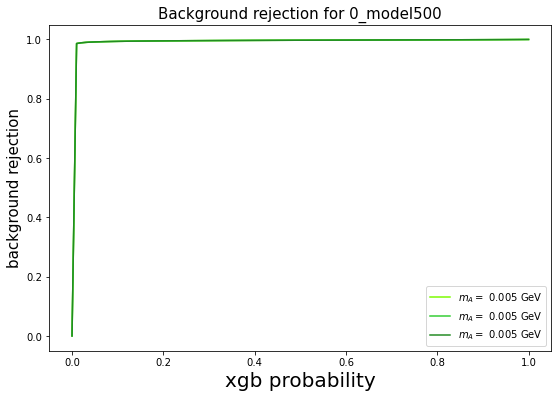

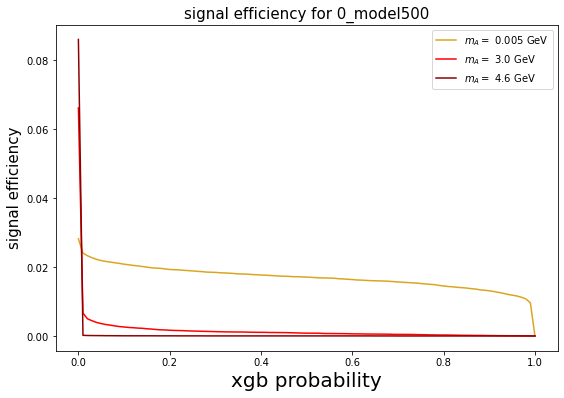

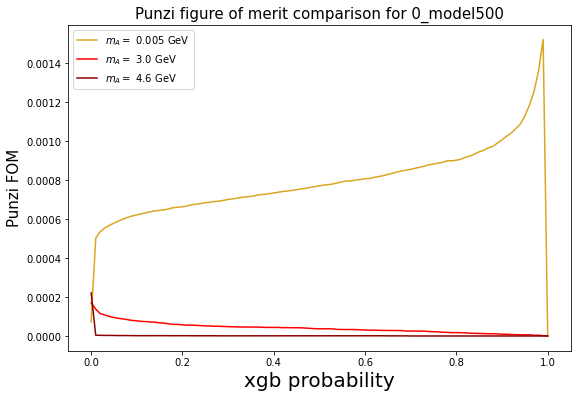

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import pyarrow as pa
import pyarrow.parquet as pq
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import functions as fc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


data = ["0_large","3_large","4_large"]

TP = []
FP = []
pfom_list = []
AUC = []
background_eff = []
signal_eff = []
binning = np.linspace(0,1,21)
estimator = 500
for index in range(len(data)):
        print(f"Reading {data[index]}...")
        df = pq.read_table(f"/ceph/aavocone/Datasets/{data[index]}.parquet")
        df = df.to_pandas()

        print("Completed!\n")
        print("Splitting Dataset:")
        X = df[df.columns[:-1]]    #exclude "signal" "classification"
        y = df["signal"]            
        xtrain,xtest,ytrain,ytest = train_test_split(X, y, test_size = 0.33, stratify = y)
        xtrain,xval,ytrain,yval = train_test_split(xtrain, ytrain, test_size = 0.5,stratify=ytrain)
        print("Completed!\n")

        print("Getting probability from trainingsset and testingset")
        model = XGBClassifier()
        model.load_model("/ceph/aavocone/models/new_0_0_model500.txt")
        y_train = model.predict_proba(xtrain)[:,1]
        yprob = model.predict_proba(xtest)[:,1]
        print("Completed!\n")
        print("Getting efficiency values:")
        sh_train,bh_train,s_train,b_train,bin_edges = fc.efficiency(y_train,ytrain, eff_type = 1)
        sh,bh,s,b,bin_edges = fc.efficiency(yprob,ytest, eff_type = 1)
        background_eff.append(b)
        signal_eff.append(s)
        print("Completed!\n")
        auc =roc_auc_score(ytest,yprob)
        fp,tp, thresh = roc_curve(ytest, yprob)
        TP.append(tp)
        FP.append(fp)
        AUC.append(auc)
        pfom_list.append(fc.PFOM(s,b,bh,5))

        plt.figure(figsize=(9,6))
        plt.hist(bh_train,bins = binning, density=True, histtype="step", label = "train set", color = "forestgreen")
        plt.hist(bh,bins = binning, density=True, histtype="stepfilled", label = "test set", color = "springgreen", alpha = 0.5)
        plt.title(f"normalized background histogram\nmodel = 0.005GeV,n={estimator}\n set: {data[index]}  ")
        plt.ylabel("Entries / ({:.2f} unit)".format(binning[1]-binning[0]), fontsize = 15)
        plt.xlabel("xgb probability", fontsize = 20)
        plt.legend()
        plt.savefig(f"/work/aavocone/week10/cross_mass/{data[index]}_mA0_{estimator}_overtrain_background.pdf", format="pdf",bbox_inches="tight")
        plt.show() 

        #signal
        plt.figure(figsize=(9,6))
        plt.hist(sh_train,bins = binning, density=True, histtype="step", label = "train set", color = "brown")
        plt.hist(sh,bins = binning, density=True, histtype="stepfilled", label = "test set", color = "coral", alpha = 0.5)
        plt.title(f"normalized signal histogram \nmodel = 0.005GeV,n={estimator}\n set: {data[index]}")
        plt.ylabel("Entries / ({:.2f} unit)".format(binning[1]-binning[0]), fontsize = 15)
        plt.xlabel("xgb probability", fontsize = 20)
        plt.legend()
        plt.savefig(f"/work/aavocone/week10/cross_mass/{data[index]}_mA0_{estimator}_overtrain_signal.pdf", format="pdf",bbox_inches="tight")
        plt.show()


        #histogram
        plt.figure(figsize=(9,6))
        plt.hist(bh,bins = bin_edges, density=True, histtype="step", label = "background", color = "g")
        plt.hist(sh,bins = bin_edges, density=True, histtype="step", label = "signal", color = "r")
        plt.title(f"normalized histogram \nmodel = 0.005GeV,n={estimator}\n set: {data[index]}  ")
        plt.ylabel("Entries / ({:.2f} unit)".format(bin_edges[1]-bin_edges[0]), fontsize = 15)
        plt.xlabel("xgb probability", fontsize = 20)
        plt.legend()
        plt.savefig(f"/work/aavocone/week10/cross_mass/{data[index]}_mA0_{estimator}__histogram.pdf", format="pdf",bbox_inches="tight")
        plt.show()

#signal efficiency background rejection
plt.figure(figsize=(9,6))
plt.plot(bin_edges, 1-background_eff[0], label = "$m_A =$ 0.005 GeV", color ="lawngreen")
plt.plot(bin_edges, 1-background_eff[1], label = "$m_A =$ 0.005 GeV", color ="limegreen")
plt.plot(bin_edges, 1-background_eff[2], label = "$m_A =$ 0.005 GeV", color ="forestgreen")
plt.xlabel("xgb probability", fontsize = 20)
plt.ylabel("background rejection", fontsize = 15)
plt.title(f"Background rejection for 0_model500", fontsize = 15)
plt.legend()
plt.savefig(f"/work/aavocone/week10/cross_mass/mA0_500_background_reject.pdf", format="pdf",bbox_inches="tight")
plt.show() 

plt.figure(figsize=(9,6))
plt.plot(bin_edges, signal_eff[0], label = "$m_A =$ 0.005 GeV", color = "goldenrod")
plt.plot(bin_edges, signal_eff[1], label = "$m_A =$ 3.0 GeV", color = "r")
plt.plot(bin_edges, signal_eff[2], label = "$m_A =$ 4.6 GeV", color = "darkred")
plt.xlabel("xgb probability", fontsize = 20)
plt.ylabel("signal efficiency",fontsize=15)
plt.title(f"signal efficiency for 0_model500", fontsize = 15)
plt.legend()
plt.savefig(f"/work/aavocone/week10/cross_mass/mA0_500_signal_eff.pdf", format="pdf",bbox_inches="tight")
plt.show()

plt.figure(figsize=(9,6))
plt.plot(bin_edges, pfom_list[0], label = "$m_A =$ 0.005 GeV", color ="goldenrod")
plt.plot(bin_edges, pfom_list[1], label = "$m_A =$ 3.0 GeV", color ="red")
plt.plot(bin_edges, pfom_list[2], label = "$m_A =$ 4.6 GeV", color ="darkred")
plt.title("Punzi figure of merit comparison for 0_model500",fontsize=15)
plt.ylabel("Punzi FOM",fontsize=15)
plt.xlabel("xgb probability", fontsize = 20)
plt.legend()
plt.savefig(f"/work/aavocone/week10/cross_mass/PFOM_mA0_500.pdf", format="pdf",bbox_inches="tight")
plt.show()


# $m_A = 3.0$ GeV

## Individual plots

Reading 0_large...
Completed!

Splitting Dataset:
Number of columns: 15
Completed!

Getting probability from training set and testing set
Completed!

Getting efficiency values:
Reconstruction efficiency with n=100.000 calculated.
Reconstruction efficiency with n=100.000 calculated.
Completed!



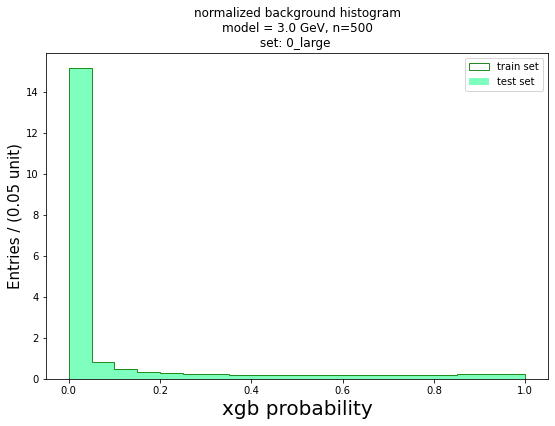

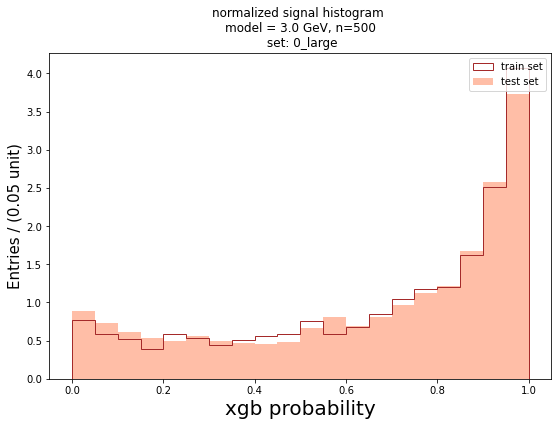

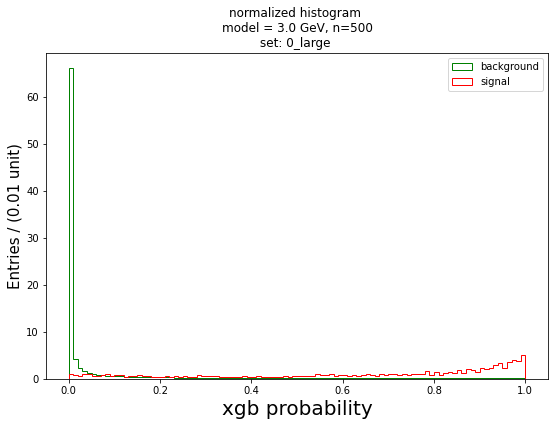

Reading 3_large...
Completed!

Splitting Dataset:
Number of columns: 15
Completed!

Getting probability from training set and testing set
Completed!

Getting efficiency values:
Reconstruction efficiency with n=100.000 calculated.
Reconstruction efficiency with n=100.000 calculated.
Completed!



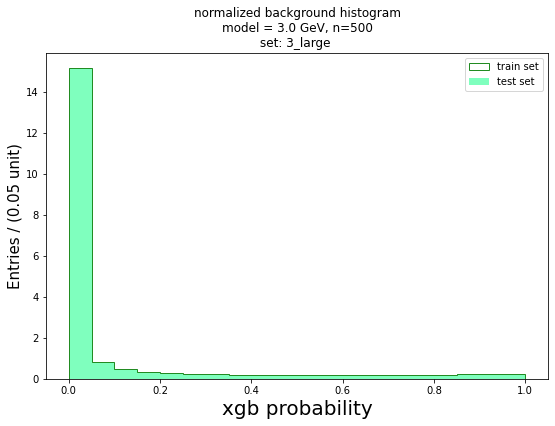

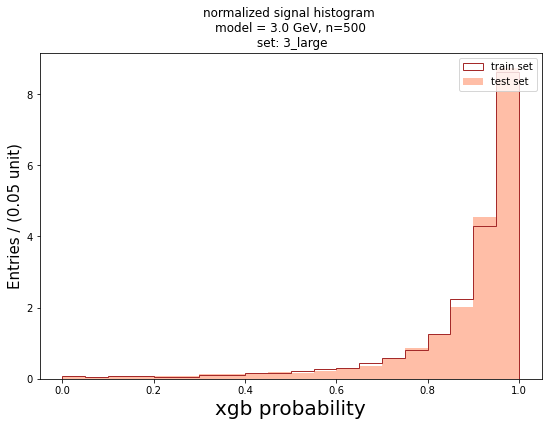

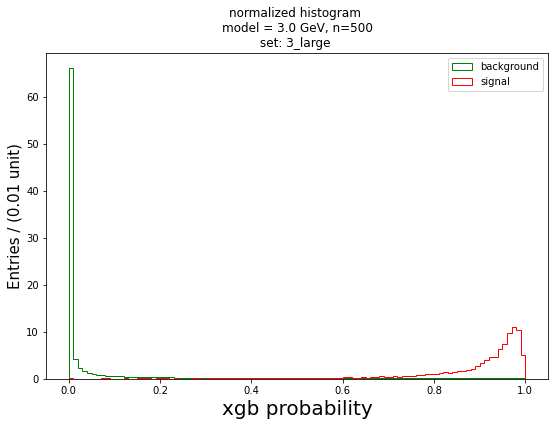

Reading 4_large...
Completed!

Splitting Dataset:
Number of columns: 15
Completed!

Getting probability from training set and testing set
Completed!

Getting efficiency values:
Reconstruction efficiency with n=100.000 calculated.
Reconstruction efficiency with n=100.000 calculated.
Completed!



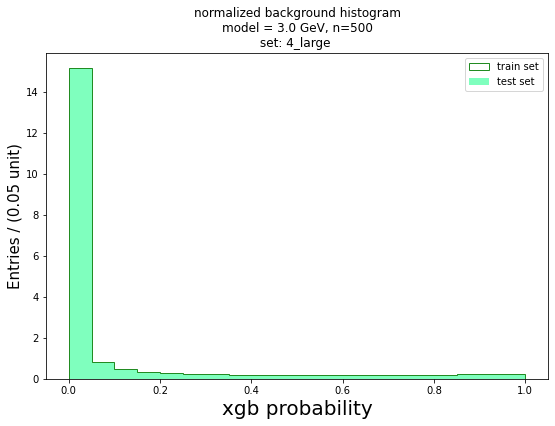

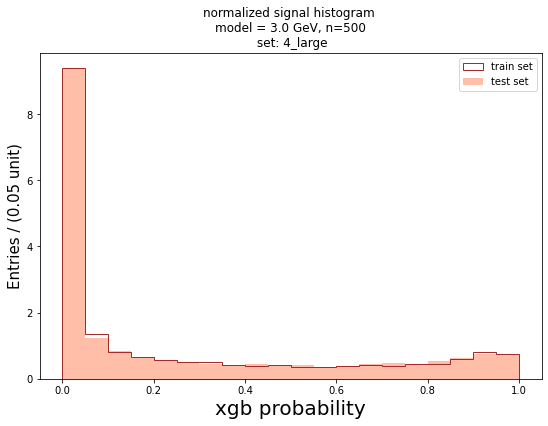

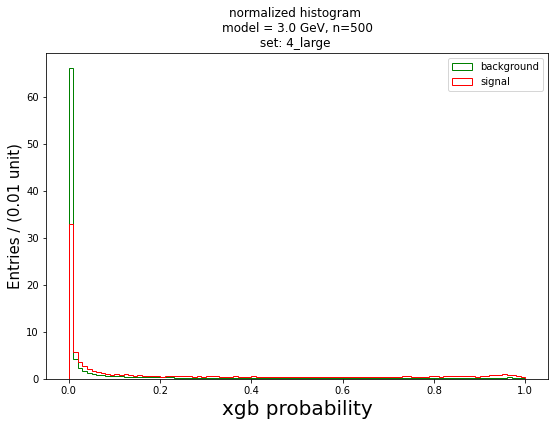

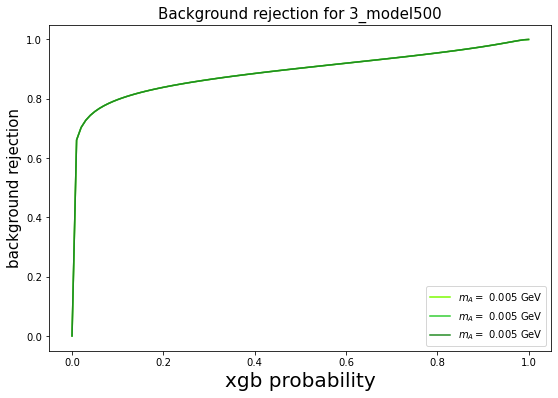

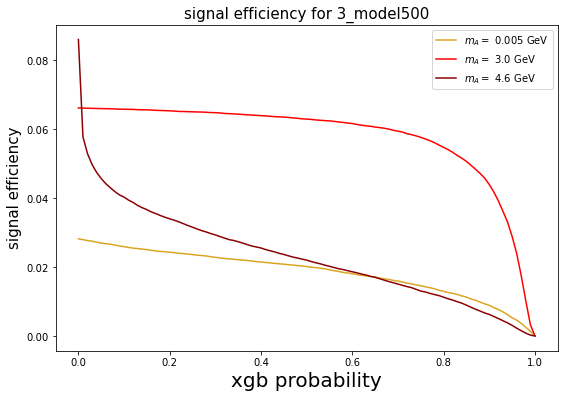

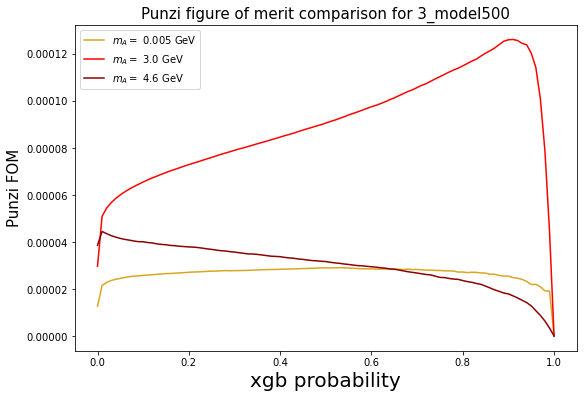

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import pyarrow as pa
import pyarrow.parquet as pq
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import functions as fc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

data = ["0_large","3_large","4_large"]
TP = []
FP = []
pfom_list = []
AUC = []
background_eff = []
signal_eff = []
binning = np.linspace(0,1,21)
estimator = 500

model = XGBClassifier()
model.load_model("/work/aavocone/models/model500.txt")

for index in range(len(data)):
        print(f"Reading {data[index]}...")
        df = pq.read_table(f"/ceph/aavocone/Datasets/{data[index]}.parquet")
        df = df.to_pandas()

        print("Completed!\n")
        print("Splitting Dataset:")
        X = df[df.columns[:-1]]    #exclude "signal" "classification"
        y = df["signal"]            
        print("Number of columns:", len(X.columns))

        xtrain,xtest,ytrain,ytest = train_test_split(X, y, test_size = 0.33, stratify = y)
        xtrain,xval,ytrain,yval = train_test_split(xtrain, ytrain, test_size = 0.5,stratify=ytrain)
        print("Completed!\n")

        print("Getting probability from training set and testing set")

        y_train = model.predict_proba(xtrain)[:,1]
        yprob = model.predict_proba(xtest)[:,1]
        print("Completed!\n")
        print("Getting efficiency values:")
        sh_train,bh_train,s_train,b_train,bin_edges = fc.efficiency(y_train,ytrain, eff_type = 1)
        sh,bh,s,b,bin_edges = fc.efficiency(yprob,ytest, eff_type = 1)
        background_eff.append(b)
        signal_eff.append(s)
        print("Completed!\n")
        auc =roc_auc_score(ytest,yprob)
        fp,tp, thresh = roc_curve(ytest, yprob)
        TP.append(tp)
        FP.append(fp)
        AUC.append(auc)
        pfom_list.append(fc.PFOM(s,b,bh,5))

        plt.figure(figsize=(9,6))
        plt.hist(bh_train,bins = binning, density=True, histtype="step", label = "train set", color = "forestgreen")
        plt.hist(bh,bins = binning, density=True, histtype="stepfilled", label = "test set", color = "springgreen", alpha = 0.5)
        plt.title(f"normalized background histogram\nmodel = 3.0 GeV, n={estimator}\n set: {data[index]}  ")
        plt.ylabel("Entries / ({:.2f} unit)".format(binning[1]-binning[0]), fontsize = 15)
        plt.xlabel("xgb probability", fontsize = 20)
        plt.legend()
        plt.savefig(f"/work/aavocone/week10/cross_mass/{data[index]}_mA3_{estimator}_overtrain_background.pdf", format="pdf",bbox_inches="tight")
        plt.show() 

        #signal
        plt.figure(figsize=(9,6))
        plt.hist(sh_train,bins = binning, density=True, histtype="step", label = "train set", color = "brown")
        plt.hist(sh,bins = binning, density=True, histtype="stepfilled", label = "test set", color = "coral", alpha = 0.5)
        plt.title(f"normalized signal histogram \nmodel = 3.0 GeV, n={estimator}\n set: {data[index]}")
        plt.ylabel("Entries / ({:.2f} unit)".format(binning[1]-binning[0]), fontsize = 15)
        plt.xlabel("xgb probability", fontsize = 20)
        plt.legend()
        plt.savefig(f"/work/aavocone/week10/cross_mass/{data[index]}_mA3_{estimator}_overtrain_signal.pdf", format="pdf",bbox_inches="tight")
        plt.show()


        #histogram
        plt.figure(figsize=(9,6))
        plt.hist(bh,bins = bin_edges, density=True, histtype="step", label = "background", color = "g")
        plt.hist(sh,bins = bin_edges, density=True, histtype="step", label = "signal", color = "r")
        plt.title(f"normalized histogram \nmodel = 3.0 GeV, n={estimator}\n set: {data[index]}  ")
        plt.ylabel("Entries / ({:.2f} unit)".format(bin_edges[1]-bin_edges[0]), fontsize = 15)
        plt.xlabel("xgb probability", fontsize = 20)
        plt.legend()
        plt.savefig(f"/work/aavocone/week10/cross_mass/{data[index]}_mA3_{estimator}__histogram.pdf", format="pdf",bbox_inches="tight")
        plt.show()

#signal efficiency background rejection
plt.figure(figsize=(9,6))
plt.plot(bin_edges, 1-background_eff[0], label = "$m_A =$ 0.005 GeV", color ="lawngreen")
plt.plot(bin_edges, 1-background_eff[1], label = "$m_A =$ 0.005 GeV", color ="limegreen")
plt.plot(bin_edges, 1-background_eff[2], label = "$m_A =$ 0.005 GeV", color ="forestgreen")
plt.xlabel("xgb probability", fontsize = 20)
plt.ylabel("background rejection", fontsize = 15)
plt.title(f"Background rejection for 3_model500", fontsize = 15)
plt.legend()
plt.savefig(f"/work/aavocone/week10/cross_mass/mA3_500_background_reject.pdf", format="pdf",bbox_inches="tight")
plt.show() 

plt.figure(figsize=(9,6))
plt.plot(bin_edges, signal_eff[0], label = "$m_A =$ 0.005 GeV", color = "goldenrod")
plt.plot(bin_edges, signal_eff[1], label = "$m_A =$ 3.0 GeV", color = "r")
plt.plot(bin_edges, signal_eff[2], label = "$m_A =$ 4.6 GeV", color = "darkred")
plt.xlabel("xgb probability", fontsize = 20)
plt.ylabel("signal efficiency",fontsize=15)
plt.title(f"signal efficiency for 3_model500", fontsize = 15)
plt.legend()
plt.savefig(f"/work/aavocone/week10/cross_mass/mA3_500_signal_eff.pdf", format="pdf",bbox_inches="tight")
plt.show()

plt.figure(figsize=(9,6))
plt.plot(bin_edges, pfom_list[0], label = "$m_A =$ 0.005 GeV", color ="goldenrod")
plt.plot(bin_edges, pfom_list[1], label = "$m_A =$ 3.0 GeV", color ="red")
plt.plot(bin_edges, pfom_list[2], label = "$m_A =$ 4.6 GeV", color ="darkred")
plt.title("Punzi figure of merit comparison for 3_model500",fontsize=15)
plt.ylabel("Punzi FOM",fontsize=15)
plt.xlabel("xgb probability", fontsize = 20)
plt.legend()
plt.savefig(f"/work/aavocone/week10/cross_mass/PFOM_mA3_500.pdf", format="pdf",bbox_inches="tight")
plt.show()




# $m_A = 4.6 $ GeV

## model n = 500

Reading 0_large...
Completed!

Splitting Dataset:
Number of columns: 15
Completed!

Getting probability from training set and testing set
Completed!

Getting efficiency values:
Reconstruction efficiency with n=100.000 calculated.
Reconstruction efficiency with n=100.000 calculated.
Completed!



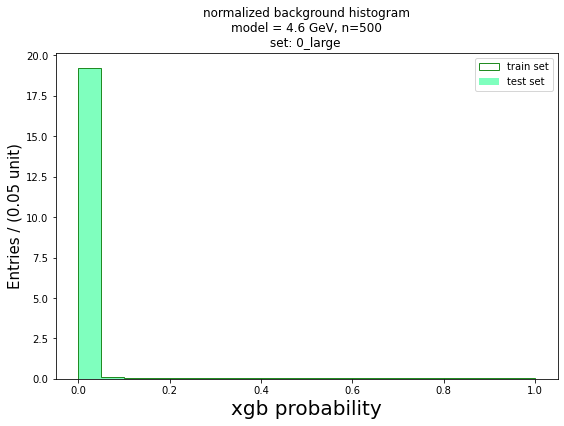

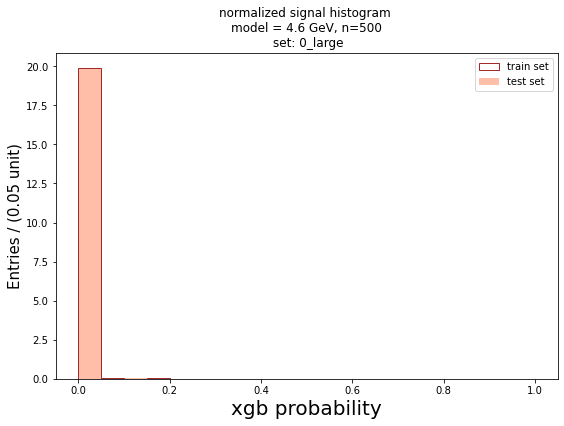

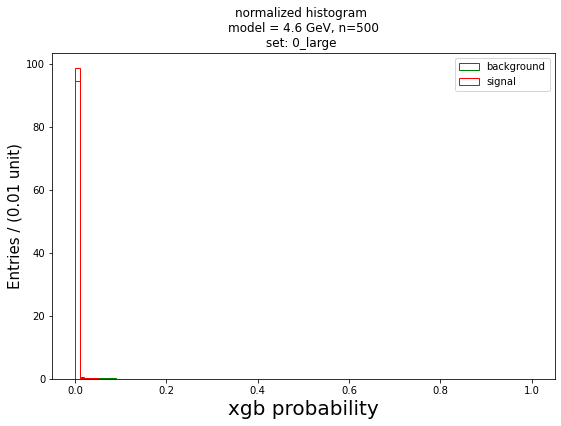

Reading 3_large...
Completed!

Splitting Dataset:
Number of columns: 15
Completed!

Getting probability from training set and testing set
Completed!

Getting efficiency values:
Reconstruction efficiency with n=100.000 calculated.
Reconstruction efficiency with n=100.000 calculated.
Completed!



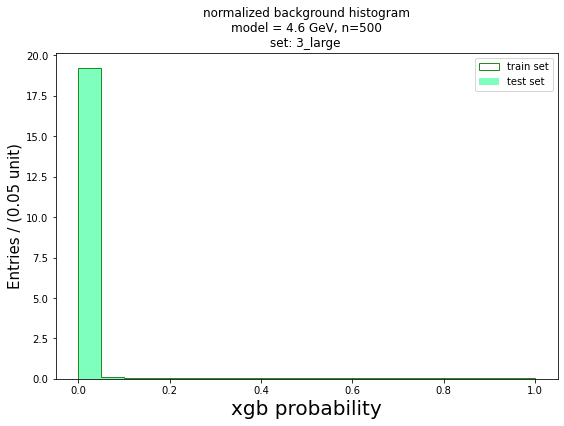

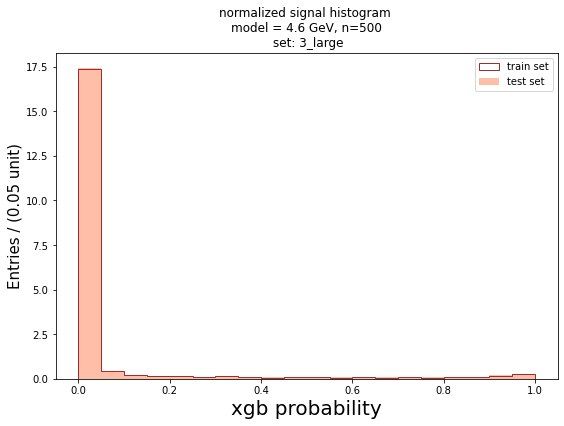

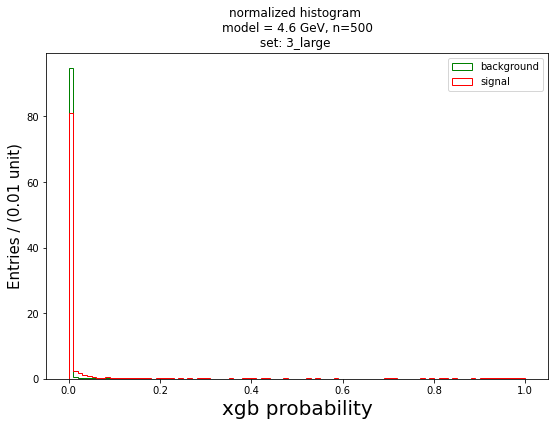

Reading 4_large...
Completed!

Splitting Dataset:
Number of columns: 15
Completed!

Getting probability from training set and testing set
Completed!

Getting efficiency values:
Reconstruction efficiency with n=100.000 calculated.
Reconstruction efficiency with n=100.000 calculated.
Completed!



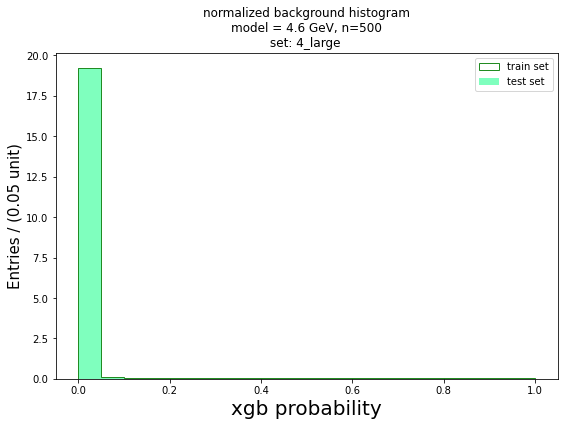

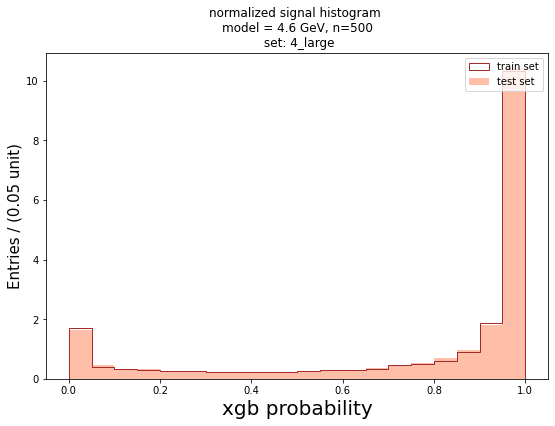

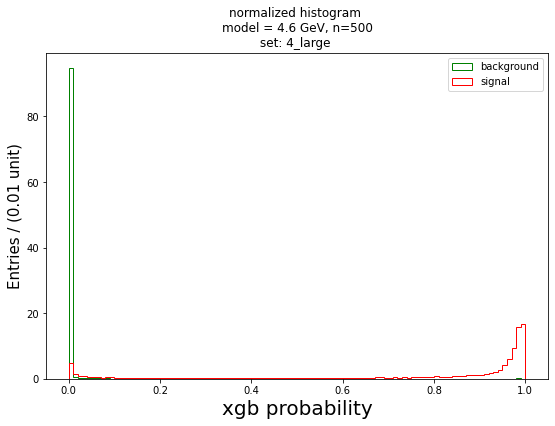

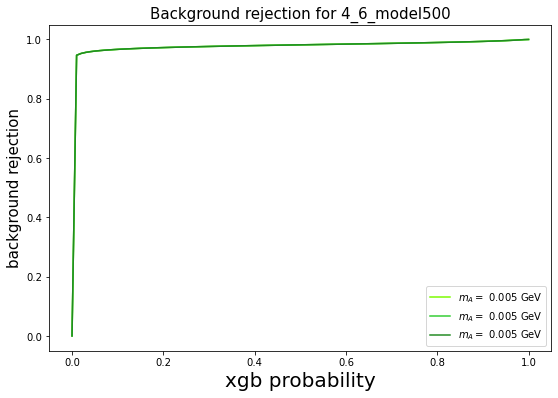

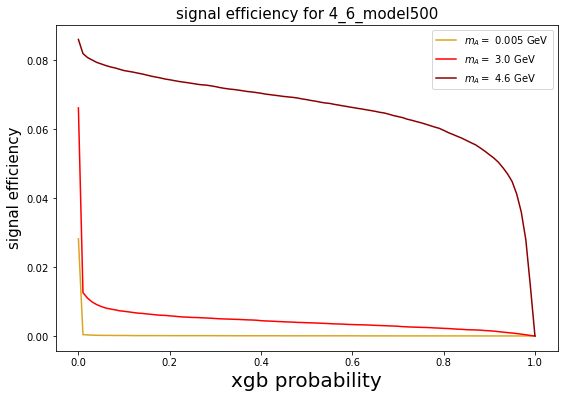

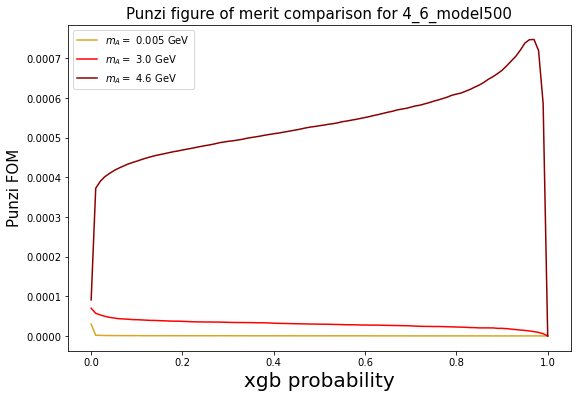

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import pyarrow as pa
import pyarrow.parquet as pq
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import functions as fc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

data = ["0_large","3_large","4_large"]
TP = []
FP = []
pfom_list = []
AUC = []
background_eff = []
signal_eff = []

binning = np.linspace(0,1,21)
estimator = 500

model = XGBClassifier()
model.load_model("/ceph/aavocone/models/new_4_6_model500.txt")

for index in range(len(data)):
        print(f"Reading {data[index]}...")
        df = pq.read_table(f"/ceph/aavocone/Datasets/{data[index]}.parquet")
        df = df.to_pandas()

        print("Completed!\n")
        print("Splitting Dataset:")
        X = df[df.columns[:-1]]    #exclude "signal" "classification"
        y = df["signal"]            
        print("Number of columns:", len(X.columns))
        xtrain,xtest,ytrain,ytest = train_test_split(X, y, test_size = 0.33, stratify = y)
        xtrain,xval,ytrain,yval = train_test_split(xtrain, ytrain, test_size = 0.5,stratify=ytrain)
        print("Completed!\n")

        print("Getting probability from training set and testing set")

        y_train = model.predict_proba(xtrain)[:,1]
        yprob = model.predict_proba(xtest)[:,1]
        print("Completed!\n")
        print("Getting efficiency values:")
        sh_train,bh_train,s_train,b_train,bin_edges = fc.efficiency(y_train,ytrain, eff_type = 1)
        sh,bh,s,b,bin_edges = fc.efficiency(yprob,ytest, eff_type = 1)
        background_eff.append(b)
        signal_eff.append(s)
        pfom_list.append(fc.PFOM(s,b,bh,5))
        auc =roc_auc_score(ytest,yprob)
        fp,tp, thresh = roc_curve(ytest, yprob)
        TP.append(tp)
        FP.append(fp)
        AUC.append(auc)
        print("Completed!\n")

        plt.figure(figsize=(9,6))
        plt.hist(bh_train,bins = binning, density=True, histtype="step", label = "train set", color = "forestgreen")
        plt.hist(bh,bins = binning, density=True, histtype="stepfilled", label = "test set", color = "springgreen", alpha = 0.5)
        plt.title(f"normalized background histogram\nmodel = 4.6 GeV, n={estimator}\n set: {data[index]}  ")
        plt.ylabel("Entries / ({:.2f} unit)".format(binning[1]-binning[0]), fontsize = 15)
        plt.xlabel("xgb probability", fontsize = 20)
        plt.legend()
        plt.savefig(f"/work/aavocone/week10/cross_mass/{data[index]}_mA4_{estimator}_overtrain_background.pdf", format="pdf",bbox_inches="tight")
        plt.show() 

        #signal
        plt.figure(figsize=(9,6))
        plt.hist(sh_train,bins = binning, density=True, histtype="step", label = "train set", color = "brown")
        plt.hist(sh,bins = binning, density=True, histtype="stepfilled", label = "test set", color = "coral", alpha = 0.5)
        plt.title(f"normalized signal histogram \nmodel = 4.6 GeV, n={estimator}\n set: {data[index]}")
        plt.ylabel("Entries / ({:.2f} unit)".format(binning[1]-binning[0]), fontsize = 15)
        plt.xlabel("xgb probability", fontsize = 20)
        plt.legend()
        plt.savefig(f"/work/aavocone/week10/cross_mass/{data[index]}_mA4_{estimator}_overtrain_signal.pdf", format="pdf",bbox_inches="tight")
        plt.show()


        #histogram
        plt.figure(figsize=(9,6))
        plt.hist(bh,bins = bin_edges, density=True, histtype="step", label = "background", color = "g")
        plt.hist(sh,bins = bin_edges, density=True, histtype="step", label = "signal", color = "r")
        plt.title(f"normalized histogram \nmodel = 4.6 GeV, n={estimator}\n set: {data[index]}  ")
        plt.ylabel("Entries / ({:.2f} unit)".format(bin_edges[1]-bin_edges[0]), fontsize = 15)
        plt.xlabel("xgb probability", fontsize = 20)
        plt.legend()
        plt.savefig(f"/work/aavocone/week10/cross_mass/{data[index]}_mA4_{estimator}__histogram.pdf", format="pdf",bbox_inches="tight")
        plt.show()

#signal efficiency background rejection
plt.figure(figsize=(9,6))
plt.plot(bin_edges, 1-background_eff[0], label = "$m_A =$ 0.005 GeV", color ="lawngreen")
plt.plot(bin_edges, 1-background_eff[1], label = "$m_A =$ 0.005 GeV", color ="limegreen")
plt.plot(bin_edges, 1-background_eff[2], label = "$m_A =$ 0.005 GeV", color ="forestgreen")
plt.xlabel("xgb probability", fontsize = 20)
plt.ylabel("background rejection", fontsize = 15)
plt.title(f"Background rejection for 4_6_model500", fontsize = 15)
plt.legend()
plt.savefig(f"/work/aavocone/week10/cross_mass/mA4_500_background_reject.pdf", format="pdf",bbox_inches="tight")
plt.show() 

plt.figure(figsize=(9,6))
plt.plot(bin_edges, signal_eff[0], label = "$m_A =$ 0.005 GeV", color = "goldenrod")
plt.plot(bin_edges, signal_eff[1], label = "$m_A =$ 3.0 GeV", color = "r")
plt.plot(bin_edges, signal_eff[2], label = "$m_A =$ 4.6 GeV", color = "darkred")
plt.xlabel("xgb probability", fontsize = 20)
plt.ylabel("signal efficiency",fontsize=15)
plt.title(f"signal efficiency for 4_6_model500", fontsize = 15)
plt.legend()
plt.savefig(f"/work/aavocone/week10/cross_mass/mA4_500_signal_eff.pdf", format="pdf",bbox_inches="tight")
plt.show()

plt.figure(figsize=(9,6))
plt.plot(bin_edges, pfom_list[0], label = "$m_A =$ 0.005 GeV", color ="goldenrod")
plt.plot(bin_edges, pfom_list[1], label = "$m_A =$ 3.0 GeV", color ="red")
plt.plot(bin_edges, pfom_list[2], label = "$m_A =$ 4.6 GeV", color ="darkred")
plt.title("Punzi figure of merit comparison for 4_6_model500",fontsize=15)
plt.ylabel("Punzi FOM",fontsize=15)
plt.xlabel("xgb probability", fontsize = 20)
plt.legend()
plt.savefig(f"/work/aavocone/week10/cross_mass/PFOM_mA4_500.pdf", format="pdf",bbox_inches="tight")
plt.show()

